In [1]:
# Standard data analysis libraries
import pandas as pd
import numpy as np

# Data visualization libraries
from seaborn import heatmap
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Transformers libraries
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


# Machine learning models
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Cross Validation
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
# Metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score,roc_auc_score
# Hyperparameter tuning library
from sklearn.model_selection import GridSearchCV


In [2]:
df = pd.read_csv('train.csv',index_col = 'PassengerId')
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.drop(['Name'],axis = 'columns',inplace = True) # Name will not be useful for the data analysis neither for the algorithms

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 76.6+ KB


<Axes: ylabel='PassengerId'>

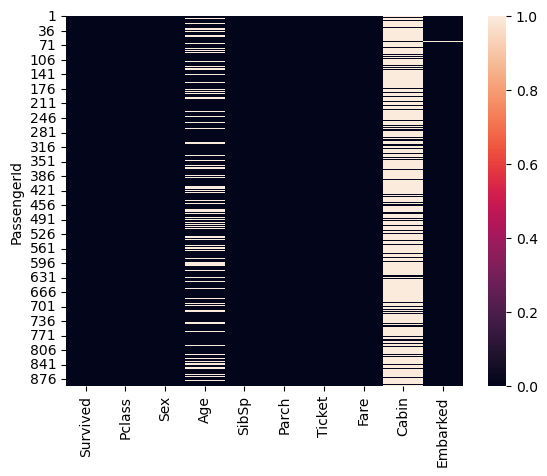

In [5]:
heatmap(df.isna())

<b>Embarked</b>, <b>Cabin</b> and <b>Age</b> attributes have missing values

## Data Cleaning

<b>Embarked</b>

In [6]:
df.dropna(subset = 'Embarked',axis = 0,inplace = True) #dropping the 2 rows with NaN's on embarked attribute

<b>Cabin</b>

In [7]:
total_instances = df.shape[0]
total_instances

889

In [8]:
cabin_missing = df['Cabin'].isna().sum()
cabin_missing

687

In [9]:
print('The percentage of missing values in the Cabin column is {} %'.format(np.around((cabin_missing*100)/total_instances),2))

The percentage of missing values in the Cabin column is 77.0 %


Due to the high percentage of missing data in the cabin column, it will be droped from the dataset.

In [10]:
df.drop(['Cabin'],axis = 'columns',inplace = True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,A/5 21171,7.2500,S
2,1,1,female,38.0,1,0,PC 17599,71.2833,C
3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1,1,female,35.0,1,0,113803,53.1000,S
5,0,3,male,35.0,0,0,373450,8.0500,S


<b>Age</b>

In [11]:
age_missing = df['Age'].isna().sum()
age_missing 

177

In [12]:
print('The number of instances with age missing are {} %'.format(np.around(age_missing*100/total_instances )))

The number of instances with age missing are 20.0 %


To avoid lose more data and because 20% doesn't seem so high we're going to fill the missing values with the average of the age column

In [13]:
age_mean = df['Age'].mean()
df['Age'].fillna(value = age_mean,inplace = True)

In [14]:
df['Age'].notna().sum()

889

Since the same steps will be applied to test data, we can build a transformer for it:

In [15]:
class DataCleaner(BaseException,TransformerMixin):
    def fit(self,X,y= None):
        return self
    def transform(self,X,y = None):
        # Drop rows with NaN's on 'Embarked' attribute
        X.dropna(subset = 'Embarked',axis = 0,inplace = True) 
        # Drop 'Cabin' attribute
        X.drop(['Cabin'],axis = 'columns',inplace = True)
        # Fill the NaN's from the 'Age' attribute
        age_mean = X['Age'].mean()
        X['Age'].fillna(value = age_mean,inplace = True)
        return X




In [16]:
#Analyzing the data for each column
for col in df.columns:
    print(df[col].value_counts().sort_values(ascending = False))

Survived
0    549
1    340
Name: count, dtype: int64
Pclass
3    491
1    214
2    184
Name: count, dtype: int64
Sex
male      577
female    312
Name: count, dtype: int64
Age
29.642088    177
24.000000     30
22.000000     27
18.000000     26
28.000000     25
            ... 
66.000000      1
0.666700       1
0.416700       1
34.500000      1
74.000000      1
Name: count, Length: 89, dtype: int64
SibSp
0    606
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64
Parch
0    676
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64
Ticket
347082              7
1601                7
CA. 2343            7
3101295             6
CA 2144             6
                   ..
2683                1
SOTON/O2 3101287    1
11774               1
392092              1
370376              1
Name: count, Length: 680, dtype: int64
Fare
8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
8.6833      1
8.3625      1
8.433

<b>Some Conclusions:</b>
<p>The ship had more males than females</p>
<p>The passengers on the ship came mainly from Southampton</p>
<p>The third class has more passengers than the other classes</p>

### Outliers

<Axes: title={'center': 'Fare'}, xlabel='Fare'>

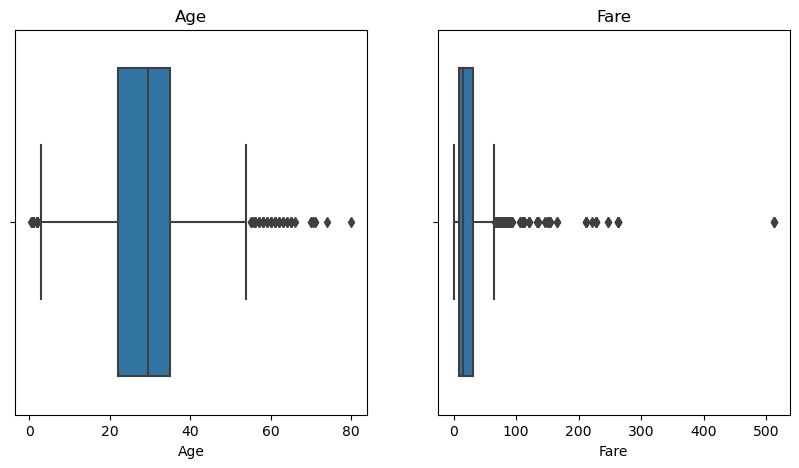

In [17]:
numerical_attributes = ['Age','Fare']
plt.figure(figsize = (10,5))
ax1 = plt.subplot(1,2,1)
ax1.set_title('Age')
sns.boxplot(x = df[numerical_attributes[0]])
ax2 = plt.subplot(1,2,2)
ax2.set_title('Fare')
sns.boxplot(x = df[numerical_attributes[1]])


Above we can see that there is a fair number of outliers in these numerical attributes. We may treat them in the preprocessing

## EDA

<b>Sex feature</b>

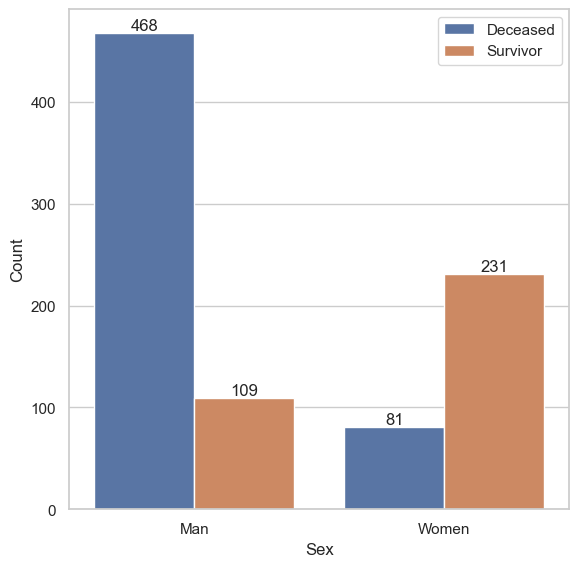

In [30]:
fig = plt.figure(figsize = (5,5))
ax = fig.add_axes([0,0,1,1])
sns.countplot(df,x = 'Sex',hue = 'Survived')
sns.set_theme(style = 'whitegrid')
ax.set_xticks([0,1],('Man','Women'))
ax.set_xlabel('Sex',fontsize = 12)
ax.set_ylabel('Count',fontsize = 12)
ax.legend(['Deceased','Survived'])

for label in ax.containers:
    ax.bar_label(label)

In [27]:
cross_pclass = pd.crosstab(df.Sex,df.Survived,margins = True,normalize = 'index')
cross_pclass.rename(mapper = {0:'Deceased',1:'Survived'},axis = 'columns',inplace = True)
cross_pclass.style.background_gradient()

Survived,Deceased,Survivor
Sex,,
female,0.259615,0.740385
male,0.811092,0.188908
All,0.617548,0.382452


Women had the greatest percentage of survival

<b>Pclass feature</b>

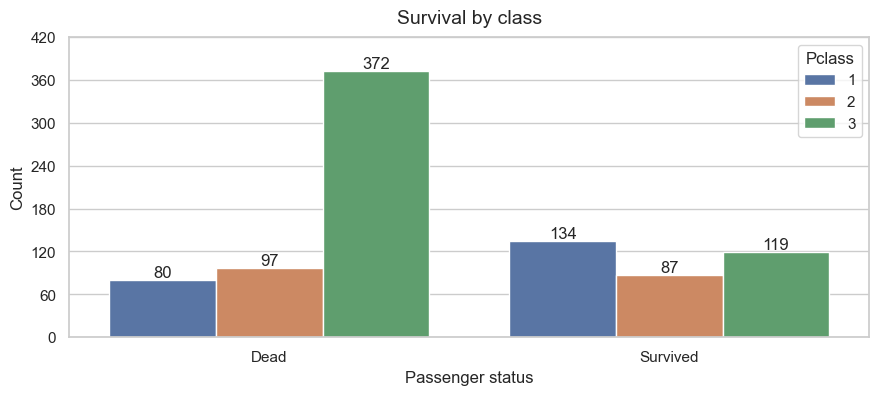

In [ ]:
fig = plt.figure(figsize = (8,3))
ax = fig.add_axes([0,0,1,1])
sns.countplot(df,x = 'Survived',hue = 'Pclass')
sns.set_theme(style = 'whitegrid')
ax.set_xticks([0,1],('Deceased','Survived'))
ax.set_yticks(np.arange(0,480,60))
ax.set_xlabel('Passenger status',fontsize = 12)
ax.set_ylabel('Count',fontsize = 12)
ax.set_title('Survival by class',fontsize = 14,pad = 10)
for label in ax.containers:
    ax.bar_label(label)

Above we can see that mainly people that were in thirst class died. However the third class had more people, therefore it might be expected. <p>We need to evaluate the relative value per class before taken some conclusion about it</p>

Text(0.5, 1.0, 'Survival by class')

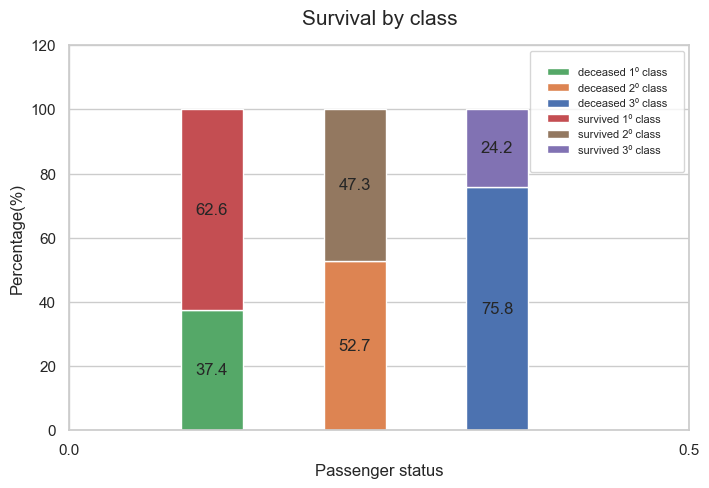

In [36]:
fig,ax = plt.subplots(figsize = (8,5))

width = 0.05
multiplier = 0
survivor_by_class = df.groupby('Survived')['Pclass'].value_counts()
for i,key in enumerate(survivor_by_class.keys()):
    # getting information from each status and class
    status_dic = {0:'deceased',1:'survived'} 
    status = key[0]
    passenger_class = key[1] 
    # calculating percentages
    frequence = survivor_by_class[key]
    total_class = survivor_by_class[(1,passenger_class)] + survivor_by_class[(0,passenger_class)]
    surv_percent = np.around((frequence*100)/total_class,1)
    # preparing position of the bars
    multiplier = passenger_class
    offset = width*multiplier*2.3
   
   # plotting bars according to the status

    if(status == 0):
        rects = ax.bar(offset,surv_percent,width,label = '{} {}º class'.format(status_dic[status],passenger_class))
        ax.bar_label(rects,label_type='center')
        
        
    elif(status == 1):
        rects = ax.bar(offset,surv_percent,width,bottom = survivor_by_class[(0,passenger_class)]*100/total_class,
                       label = '{} {}º class'.format(status_dic[status],passenger_class))
        ax.bar_label(rects,label_type='center')
    
    
#Sort legends
handles,labels = ax.get_legend_handles_labels()
labels,handles = zip(*sorted(zip(labels,handles),key = lambda t:t[0]))
ax.legend(handles,labels,loc = 'best',ncols = 1,fontsize = 8,borderpad = 1.5)

    

ax.set_xticks([0,0.5])
ax.set_yticks(np.arange(0,140,20))
ax.set_xlabel('Passenger status',fontsize = 12)
ax.set_ylabel('Percentage(%)',fontsize = 12)
ax.set_title('Survival by class',pad = 15,fontsize = 15)

<p>First class had the greatest rate of survival</p>
<p>Third class had the lowest rate of survival</p>

<b>Age feature</b>

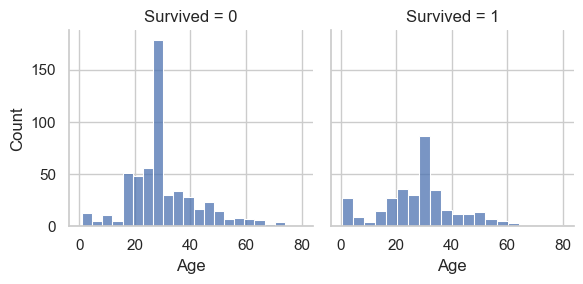

In [ ]:
g = sns.FacetGrid(df,col = 'Survived')
g.map(sns.histplot,"Age",bins = 20)

<b>SibSp feature</b>

Text(0.5, 1.0, 'Count of SibSp')

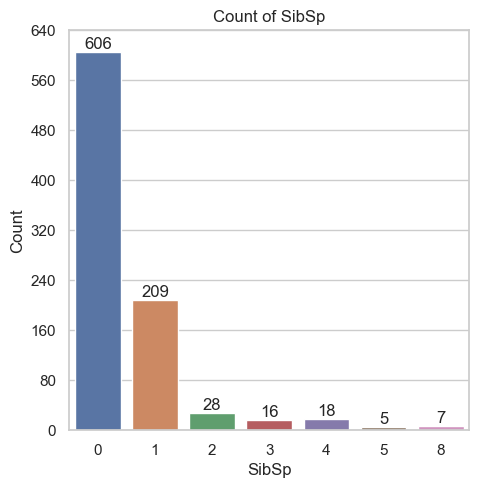

In [ ]:
fig = plt.figure(figsize = (4,4))
ax = fig.add_axes([0,0,1,1])
sns.countplot(df,x = 'SibSp')
sns.set_theme(style = 'whitegrid')
for label in ax.containers:
    ax.bar_label(label)
ax.set_ylabel('Count')
ax.set_yticks(np.arange(0,720,80))
ax.set_title('Count of SibSp')

In [ ]:
cross_sib = pd.crosstab(df.SibSp,df.Survived,margins = True,normalize = 'index')
cross_sib.rename(mapper = {0:'Deceased(%)',1:'Survived(%)'},axis = 'columns',inplace = True)
cross_sib.style.background_gradient()

Survived,Deceased(%),Survivor(%)
SibSp,,
0,0.656766,0.343234
1,0.464115,0.535885
2,0.535714,0.464286
3,0.750000,0.250000
4,0.833333,0.166667
5,1.000000,0.000000
8,1.000000,0.000000
All,0.617548,0.382452


<p>As the number of siblings increase, there might be a trend that the survival rate gets lower.</p>
<p>Still, it's worth noting that the count of passengers becomes considerably lower with the increasing of the number of siblings/spouses. Hence, this trend might not be very accurate</p>

<b>Parch feature</b>

Text(0.5, 1.0, 'Count of Parch')

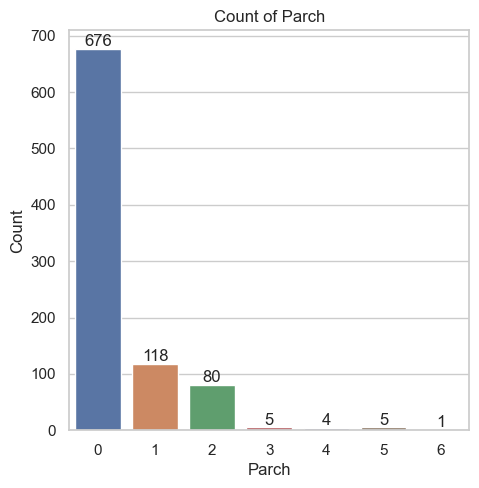

In [ ]:
fig = plt.figure(figsize = (4,4))
ax = fig.add_axes([0,0,1,1])
sns.countplot(df,x = 'Parch')
sns.set_theme(style = 'whitegrid')
for label in ax.containers:
    ax.bar_label(label)
ax.set_ylabel('Count')
ax.set_title('Count of Parch')

In [ ]:
cross_parch = pd.crosstab(df.Parch,df.Survived,margins = True,normalize = 'index')
cross_parch.rename(mapper = {0:'Deceased(%)',1:'Survived(%)'},axis = 'columns',inplace = True)
cross_parch.style.background_gradient()

Survived,Deceased(%),Survivor(%)
Parch,,
0,0.658284,0.341716
1,0.449153,0.550847
2,0.500000,0.500000
3,0.400000,0.600000
4,1.000000,0.000000
5,0.800000,0.200000
6,1.000000,0.000000
All,0.617548,0.382452


<p>Passengers with less parents/children seems to have a higher rate of survival.</p>
<p>Still, it's worth noting that the count of passengers becomes considerably lower with the increasing of the number of parent/children. Hence, this trend might not be very accurate</p>

<b>Ticket feature</b>

<b>Embarked feature</b>

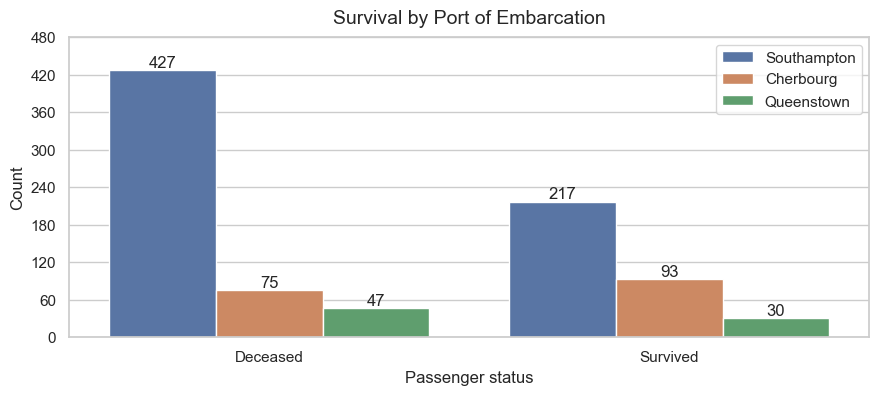

In [41]:
fig = plt.figure(figsize = (8,3))
ax = fig.add_axes([0,0,1,1])
sns.countplot(df,x = 'Survived',hue = 'Embarked')
sns.set_theme(style = 'whitegrid')
ax.set_xticks([0,1],('Deceased','Survived'))
ax.set_yticks(np.arange(0,540,60))
ax.set_xlabel('Passenger status',fontsize = 12)
ax.set_ylabel('Count',fontsize = 12)
ax.set_title('Survival by Port of Embarcation',fontsize = 14,pad = 10)
ax.legend(['Southampton','Cherbourg','Queenstown'])
for label in ax.containers:
    ax.bar_label(label)

In [42]:
cross_parch = pd.crosstab(df.Embarked,df.Survived,margins = True,normalize = 'index')
cross_parch.rename(mapper = {0:'Deceased(%)',1:'Survived(%)'},axis = 'columns',inplace = True)
cross_parch.style.background_gradient()

Survived,Deceased(%),Survived(%)
Embarked,,
C,0.446429,0.553571
Q,0.610390,0.389610
S,0.663043,0.336957
All,0.617548,0.382452


Passengers that had embarked in Southampton had the higher rate of survival

## Pre processing

In [ ]:
categorical_attributes = df.drop(numerical_attributes,axis = 'columns').columns
categorical_attributes

Index(['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Embarked'], dtype='object')

In [ ]:
for col_name in df[categorical_attributes].columns:
    unique_cat = len(df[col_name].unique())
    print("Feature '{col_name}' has {unique_cat} unique categories".format(col_name = col_name,unique_cat = unique_cat))

Feature 'Survived' has 2 unique categories
Feature 'Pclass' has 3 unique categories
Feature 'Sex' has 2 unique categories
Feature 'SibSp' has 7 unique categories
Feature 'Parch' has 7 unique categories
Feature 'Ticket' has 680 unique categories
Feature 'Embarked' has 3 unique categories


In [ ]:
X_train,y_train = df.drop('Survived',axis=1),df['Survived'] #Splitting features and labels

The most part of machine learning algorithms work better with numerical data. Hence, we're going to encode some categorical attributes.

### Categorical Attributes

In [ ]:
categorical_attributes = list(categorical_attributes)
categorical_attributes.pop(categorical_attributes.index('Survived')) #Taking off the label's name from the list
categorical_attributes

['Pclass', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Embarked']

In [ ]:
for col in categorical_attributes:
    if X_train[col].dtypes == 'object':
        print(X_train[col].value_counts())
    else:
        continue

Sex
male      577
female    312
Name: count, dtype: int64
Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 680, dtype: int64
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64


The categorical attributes that we want to encode are <b>Sex</b>,<b>Ticket</b> and <b>Embarked</b>

In [ ]:
#Evaluating the number of categories in Ticket attribute
len(X_train['Ticket'].unique())

680

<p>The ticket attribute has 680 categories. We could try to encode this attribute, but it will slow down training since there is a large number of categories.</p>
<p>In addition the fare attribute can represent as well the kind of the ticket represented by the 'Ticket' attribute</p>

Hence we can drop it.

In [ ]:
#Creating a transformer to encode and drop selected categorical attributes
class CategoricalAttributesEncoder(BaseEstimator,TransformerMixin):
    def fit(self,X,y = None):
        return self
    def transform(self,X,y = None):
        #Integer-encoding the Sex attribute
        X['Sex'] = X['Sex'].map({'male':0,'female':1}) 
        #Dropping Ticket attribute
        X.drop('Ticket',axis=1,inplace = True)
        cat_encoder = OneHotEncoder(handle_unknown='ignore')
        #Embarked attribute isn't an ordinal category, so we may use one-hot enconding
        embarked_encoded = cat_encoder.fit_transform(X[['Embarked']])
        X[cat_encoder.categories_[0]] = embarked_encoded.toarray()
        X.drop('Embarked',axis=1,inplace = True)
        return X
        
        

In [ ]:
final_cat_encoder = CategoricalAttributesEncoder()
final_cat_encoder.transform(X_train)

,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
PassengerId,,,,,,,,,
1,3,0,22.000000,1,0,7.2500,0.0,0.0,1.0
2,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0
3,3,1,26.000000,0,0,7.9250,0.0,0.0,1.0
4,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0
5,3,0,35.000000,0,0,8.0500,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
887,2,0,27.000000,0,0,13.0000,0.0,0.0,1.0
888,1,1,19.000000,0,0,30.0000,0.0,0.0,1.0
889,3,1,29.642088,1,2,23.4500,0.0,0.0,1.0


### Numerical Attributes

Some classifiers work better with scaled attributes, as SVM. Furthermore, we need to handle outliers.

In [ ]:
numerical_attributes

['Age', 'Fare']

In [ ]:
scaler = StandardScaler()
scaled_cols = scaler.fit_transform(X_train[['Age','Fare']])

In [ ]:
X_train['Age'],X_train['Fare'] = scaled_cols[:,0],scaled_cols[:,1]

In [ ]:
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
PassengerId,,,,,,,,,
1,3,0,-5.896191e-01,1,0,-0.500240,0.0,0.0,1.0
2,1,1,6.448479e-01,1,0,0.788947,1.0,0.0,0.0
3,3,1,-2.810024e-01,0,0,-0.486650,0.0,0.0,1.0
4,1,1,4.133854e-01,1,0,0.422861,0.0,0.0,1.0
5,3,0,4.133854e-01,0,0,-0.484133,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
887,2,0,-2.038482e-01,0,0,-0.384475,0.0,0.0,1.0
888,1,1,-8.210817e-01,0,0,-0.042213,0.0,0.0,1.0
889,3,1,-2.741067e-16,1,2,-0.174084,0.0,0.0,1.0


In [ ]:
# Creating a transformer to preprocess the numerical attributes
class NumericalAttributesTransformer(BaseEstimator,TransformerMixin): 
    def fit(self,X,y = None):
        return self
    def transform(self,X,y = None):
        std_scaler = StandardScaler()
        X[numerical_attributes] = std_scaler.fit_transform(X[numerical_attributes])
        return X

## Select and Train a Model

In [ ]:
def list_to_df(listt,metric_name):
    df = pd.DataFrame(listt,columns = ['Model',metric_name])
    df.set_index('Model',drop = True,inplace = True)
    return df


At first, we're going to evaluate the accuracy for each model

In [ ]:
results = []
def CrossVal(model,name,X_train,y_train):
    model.fit(X_train,y_train)
    scores = cross_val_score(model,X_train,y_train,cv = 10, scoring = 'accuracy').mean()
    results.append((name,scores))
    


In [ ]:
results = []

lin_svc_cls = LinearSVC(loss='hinge',max_iter=100000,random_state=42)
lin_svc_scores = CrossVal(lin_svc_cls,'LinearSVC',X_train,y_train)

svc_cls = SVC(kernel = 'rbf',random_state=42)
svc_scores = CrossVal(svc_cls,'SVC',X_train,y_train)

sgd_cls = SGDClassifier(random_state=42)
sgd_scores = CrossVal(sgd_cls,'SGD',X_train,y_train)

tree_cls = DecisionTreeClassifier(min_samples_leaf=10,random_state=42)
tree_scores = CrossVal(tree_cls,'Decision Tree',X_train,y_train)

forest_cls = RandomForestClassifier(random_state=42)
tree_scores = CrossVal(forest_cls,'Random Forest',X_train,y_train)

accuracy = list_to_df(results,'Accuracy')

In [ ]:
accuracy.sort_values('Accuracy',ascending = False)

,Accuracy
Model,
SVC,0.825677
Random Forest,0.813317
Decision Tree,0.806512
LinearSVC,0.786249
SGD,0.717735


<p>We can see that SVC has the best accuracy but we still <b>need to check for other metrics</b>.</p> 
<p>ROC curve will evaluate at what cost (False Positives) our model correctly classify survivors (True Positives) </p>

In [ ]:
def add_to_f1_list(model,model_name,X_train,y_train,f1_list): #Append to a list the f1 score of a selected model
    preds = cross_val_predict(model,X_train,y_train,cv=10,method = 'predict')
    f1_list.append((model_name,f1_score(y_train,preds)))


In [ ]:
auc_list = []
f1_list = []

lin_svc_y_scores = cross_val_predict(lin_svc_cls,X_train,y_train,cv=10,method = 'decision_function')
lin_svc_fpr,lin_svc_tpr,lin_svc_thresholds = roc_curve(y_train,lin_svc_y_scores)
auc_list.append(('LinearSVC',roc_auc_score(y_train,lin_svc_y_scores)))

add_to_f1_list(lin_svc_cls,'LinearSVC',X_train,y_train,f1_list)

svc_y_scores = cross_val_predict(svc_cls,X_train,y_train,cv = 10 , method = 'decision_function')
svc_fpr,svc_tpr,svc_thresholds = roc_curve(y_train,svc_y_scores)
auc_list.append(('SVC',roc_auc_score(y_train,svc_y_scores)))


add_to_f1_list(svc_cls,'SVC',X_train,y_train,f1_list)

sgd_y_scores = cross_val_predict(sgd_cls,X_train,y_train,cv = 10,method = 'decision_function')
sgd_fpr,sgd_tpr,sgd_thresholds = roc_curve(y_train,sgd_y_scores)
auc_list.append(('SGD',roc_auc_score(y_train,sgd_y_scores)))


add_to_f1_list(sgd_cls,'SGD',X_train,y_train,f1_list)

tree_y_probas = cross_val_predict(tree_cls,X_train,y_train,cv=10,method = 'predict_proba')
tree_y_scores = tree_y_probas[:,1]
tree_fpr,tree_tpr,tree_thresholds = roc_curve(y_train,tree_y_scores)
auc_list.append(('Decision Tree',roc_auc_score(y_train,tree_y_scores)))

add_to_f1_list(tree_cls,'Decision Tree',X_train,y_train,f1_list)

forest_y_probas = cross_val_predict(forest_cls,X_train,y_train,cv = 10, method = 'predict_proba')
forest_y_scores = forest_y_probas[:,1] #Using the probability of having a survivor as scores
forest_fpr,forest_tpr,forest_thresholds = roc_curve(y_train,forest_y_scores)
auc_list.append(('Random Forest',roc_auc_score(y_train,forest_y_scores)))

add_to_f1_list(forest_cls,'Random Forest',X_train,y_train,f1_list)

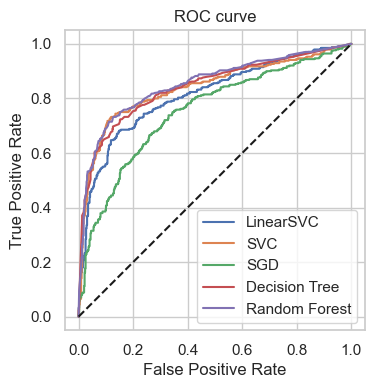

In [ ]:
fig = plt.figure(figsize = (3,3))
ax = fig.add_axes([0,0,1,1])
ax.plot(lin_svc_fpr,lin_svc_tpr,label = 'LinearSVC')
ax.plot(svc_fpr,svc_tpr,label = 'SVC')
ax.plot(sgd_fpr,sgd_tpr,label = 'SGD')
ax.plot(tree_fpr,tree_tpr,label = 'Decision Tree')
ax.plot(forest_fpr,forest_tpr,label = 'Random Forest')
ax.plot([0,1],[0,1],'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve')
ax.legend(loc = 'best')


In [ ]:
auc_df = list_to_df(auc_list,'AUC score')
auc_df.sort_values('AUC score',ascending = False)


,AUC score
Model,
Random Forest,0.852638
Decision Tree,0.842618
SVC,0.839334
LinearSVC,0.812547
SGD,0.752229


In [ ]:
f1_df = list_to_df(f1_list,'F1 score')
f1_df.sort_values('F1 score',ascending = False)

,F1 score
Model,
SVC,0.758190
Random Forest,0.750000
Decision Tree,0.733746
LinearSVC,0.708589
SGD,0.613251


In [ ]:
metrics = pd.concat((accuracy,auc_df,f1_df),axis = 1)
metrics.sort_values('F1 score',ascending = False)

,Accuracy,AUC score,F1 score
Model,,,
SVC,0.825677,0.839334,0.758190
Random Forest,0.813317,0.852638,0.750000
Decision Tree,0.806512,0.842618,0.733746
LinearSVC,0.786249,0.812547,0.708589
SGD,0.717735,0.752229,0.613251


The difference between AUC scores are not so large. Once that both True positives and True Negatives are important, we can choose the model with high Accuracy and F1 score and still has a high AUC score.

## Fine-Tune the Model

In [ ]:
params = [{'kernel':['poly'], 'degree':[3,10],'C':[0.1,1,5,10,100]},
          {'kernel':['rbf'],'C':[0.1,1,5,10,100],'gamma':[0.001,0.1,10]}]

In [ ]:
grid_cv = GridSearchCV(svc_cls,params,scoring = 'accuracy',cv = 5,return_train_score=True,refit = True)
grid_cv.fit(X_train,y_train)


GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid=[{'C': [0.1, 1, 5, 10, 100], 'degree': [3, 10],
                          'kernel': ['poly']},
                         {'C': [0.1, 1, 5, 10, 100], 'gamma': [0.001, 0.1, 10],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='accuracy')

In [ ]:
print("The best parameters found for SVC was {} and the best score achieved was {} ".format(grid_cv.best_params_,grid_cv.best_score_))

The best parameters found for SVC was {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'} and the best score achieved was 0.8279565796991049 


In [ ]:
final_svc_model = SVC(C = 10,gamma = 0.1, kernel = 'rbf',random_state=42)
final_svc_model.fit(X_train,y_train)

SVC(C=10, gamma=0.1, random_state=42)

### Final Pipeline

In [ ]:
attributes = ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked']

In [ ]:
full_pipeline = Pipeline([
    ('clean_data',DataCleaner()),
    ('cat_encoder',CategoricalAttributesEncoder()),
    ('num_transformer',NumericalAttributesTransformer()),
])

## Predicting the Test Set

In [ ]:
# Importing the test set
X_test = pd.read_csv('test.csv',index_col = 'PassengerId')
X_test.drop('Name',axis = 1,inplace = True)
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
892,3,male,34.5,0,0,330911,7.8292,NaN,Q
893,3,female,47.0,1,0,363272,7.0000,NaN,S
894,2,male,62.0,0,0,240276,9.6875,NaN,Q
895,3,male,27.0,0,0,315154,8.6625,NaN,S
896,3,female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
# Applying the pipeline on the test set
full_pipeline.transform(X_test)

,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
PassengerId,,,,,,,,,
892,3,0,0.334993,0,0,-0.497811,0.0,1.0,0.0
893,3,1,1.325530,1,0,-0.512660,0.0,0.0,1.0
894,2,0,2.514175,0,0,-0.464532,0.0,1.0,0.0
895,3,0,-0.259330,0,0,-0.482888,0.0,0.0,1.0
896,3,1,-0.655545,1,1,-0.417971,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
1305,3,0,0.000000,0,0,-0.493856,0.0,0.0,1.0
1306,1,1,0.691586,0,0,1.312180,1.0,0.0,0.0
1307,3,0,0.651965,0,0,-0.508183,0.0,0.0,1.0


In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  418 non-null    int64  
 1   Sex     418 non-null    int64  
 2   Age     418 non-null    float64
 3   SibSp   418 non-null    int64  
 4   Parch   418 non-null    int64  
 5   Fare    417 non-null    float64
 6   C       418 non-null    float64
 7   Q       418 non-null    float64
 8   S       418 non-null    float64
dtypes: float64(5), int64(4)
memory usage: 32.7 KB


The 'Fare' attribute has a missing value. We could drop the row with it, but as the titanic challenge requires to predict 418 values, we going to fill this NaN value with the mean of the column.

In [ ]:
fare_mean = X_test['Fare'].mean()
X_test['Fare'].fillna(value = fare_mean,inplace = True)

In [ ]:
# Making predictions on the test set with the best hyperparameters 
svc_cls = SVC(C = 10, gamma = 0.1, kernel = 'rbf')
svc_cls.fit(X_train,y_train)
test_preds = svc_cls.predict(X_test)

In [ ]:
# Creating a dataframe with the predictions
results = X_test.reset_index()[['PassengerId']].copy()
results['Survived'] = test_preds
results

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [ ]:
results.to_csv('predictions.csv',index = False)